In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading and importing necessary librabries.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs

In [8]:
!pip install -U sentence_transformers
from sentence_transformers import SentenceTransformer
#from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('punkt')

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 2.3MB 7.2MB/s 
     |████████████████████████████████| 1.2MB 23.9MB/s 
     |████████████████████████████████| 901kB 33.3MB/s 
     |████████████████████████████████| 3.3MB 39.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=35221264fa77816a62b5c585ad88269ffbce36f082e27eeea6d4c213e34126e7
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
d = pd.read_csv("drive/MyDrive/EE769Project/train.csv")
d.drop(['Id','CreationDate'],axis=1,inplace=True)
d.head()

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ


# Cleaning data

In [10]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"coz":"because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

EXTRA_TAGS = ['h1','h2','h3','h4','h5','h6','blockquote','b','strong','i','em','mark','small','del','ins','sub','sup']

import regex as re
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def get_text_code(soup):
    t = ''
    for i in soup.find_all('p'):
        t = t+' '+i.get_text()
    t = t.lstrip()
    c = ''
    n = 0
    for i in soup.find_all('code'):
        c = c+' '+i.get_text()
        n += 1
    c = c.lstrip()
    return t,c,n

def get_extra_tags(soup):
    n = 0
    for i in EXTRA_TAGS:
        n += len(soup.find_all(i))
    return n

def get_tags(a):
    a = a.split("<")[1:]
    l = []
    for i in a:
        l.append(i.split('>')[0])
    return l

def to_lower(text):
    return text.lower()

def removeComments(string):
    string = re.sub(re.compile("/\*.*?\*/",re.DOTALL ) ,"" ,string) # remove all occurrences streamed comments (/*COMMENT */) from string
    string = re.sub(re.compile("//.*?\n" ) ,"" ,string) # remove all occurrence single-line comments (//COMMENT\n ) from string
    string = re.sub(re.compile("#.*?\n" ) ,"" ,string) 
    string = re.sub(re.compile(' \""".*?\""" ',re.DOTALL ) ,"" ,string)
    string = re.sub(re.compile("\'''.*?\'''",re.DOTALL ) ,"" ,string)
    return string

Downloading model for sentence transformers

# Generating embeddings

In [ ]:
model = SentenceTransformer('average_word_embeddings_glove.6B.300d') # 300
#modelr2 = SentenceTransformer('stsb-roberta-base') # 768 ?
#modelr = SentenceTransformer('stsb-roberta-large') # 1024

In [11]:
def addFeatures(d):
    d['Body_statements'] = '0'
    d['Body_code'] = '0'
    d['Code_blocks'] = 0
    d['Num_Tags'] = 0
    d['Tags_str'] = ''
    d['Body_size'] = 0
    d['Extra_tags'] = 0
    d['Code_Lines'] = 0
    words = []
    for i in d.index:
        soup = bs(d.loc[i]['Body'])
        t,c,n = get_text_code(soup)
        d.at[i,'Body_statements'] = expand_contractions(to_lower(t))
        d.at[i,'Body_code'] = removeComments(c)
        d.at[i,'Code_blocks'] = n
        if n > 0:
            d.at[i,'Code_Lines'] = len(d.at[i,'Body_code'].split('\n'))
        d.at[i,'Extra_tags'] = get_extra_tags(soup)
        l = get_tags(d.loc[i]['Tags'])
        d.at[i,'Num_Tags'] = len(l)
        d.at[i,'Tags_str'] = l
        for j in l:
            words.append(j)
        sentences = d['Body_statements'][i]
        sent_text = nltk.sent_tokenize(sentences)
        d.at[i,'Body_size'] = len(sent_text)
    return d,words
    
def get_a(max_len,l):
    #a = [i for i in range(int(max_len/3))]
    #n = int(len(sent_text)/2)
    #a.extend(range(n-1,n+3))
    #a.extend([i for i in range(-int(max_len/3),0)])
    a = [i for i in range(max_len)]
    return a

def writeEmbeddings(model,max_len,d,c=300,embedding='glove',dtype='Train'):
    encoding_data = []
    num_sents = []
    for i in d.index:
        if i > 0 and i%1000==0:
            print("  Rows Completed",i)
        sentences = d['Body_statements'][i]
        sent_text = nltk.sent_tokenize(sentences)
        if len(sent_text) > max_len:
            a = get_a(max_len,len(sent_text))
            sent_text = [sent_text[i] for i in a]
        sent_embed = model.encode(sent_text)
        if len(sent_embed.shape) <= 1:
            sent_embed = np.zeros((1,c))
        if len(sent_text) < max_len:
            for j in range(max_len-sent_embed.shape[0]):
                sent_embed = np.vstack((sent_embed,np.zeros((1,c))))
        e = np.reshape(sent_embed,(-1,))
        #encoding_data = np.vstack((encoding_data,e))
        encoding_data.append(e)
    encoding_data = np.array(encoding_data)
    #encoding_data = np.delete(encoding_data,(0),axis=0)
    #print(encoding_data.shape)

    #encoding_data = encoding_data.reshape((45000,max_len*300))
    E = pd.DataFrame(data=encoding_data)
    cols = []
    for i in range(E.shape[1]):
        cols.append('Body_'+str(i+1))
    E.columns = cols
    d1 = d.drop(['Body','Body_code','Tags_str','Tags'],axis=1)
    d1 = pd.concat((d1,E),axis=1)
    title_data = []
    for i in d.index:
        sentences = d['Title'][i]
        sent_text = max(nltk.sent_tokenize(sentences),key=len)
        sent_embed = model.encode(sent_text)
        e = np.reshape(sent_embed,(1,c))
        title_data.append(e)
    title_data = np.array(title_data)
    title_data = title_data.reshape((d.shape[0],c))
    E = pd.DataFrame(data=title_data)
    cols = []
    for i in range(E.shape[1]):
        cols.append('Title_'+str(i+1))
    E.columns = cols
    d1.drop('Title',inplace=True,axis=1)
    d1 = pd.concat((d1,E),axis=1)
    d1.drop('Body_statements',axis=1,inplace=True)
    print("Dimension of data = ",d1.shape)
    d1.to_csv("drive/MyDrive/EE769Project/"+embedding+"_sent_encoding_"+dtype+"data_"+str(max_len)+"Sent.csv")
    return


Writing the embeddings of training and testing data in csvs.

In [12]:
d = pd.read_csv("drive/MyDrive/EE769Project/train.csv")
d.drop(['Id','CreationDate'],axis=1,inplace=True)
d,words = addFeatures(d)
writeEmbeddings(model,10,d)

In [ ]:
d_test = pd.read_csv("drive/MyDrive/EE769Project/valid.csv")
d_test.drop(['Id','CreationDate'],axis=1,inplace=True)
d_test,_ = addFeatures(d_test)
writeEmbeddings(model,10,d_test,dtype='Test')

  Rows Completed 1000
  Rows Completed 2000
  Rows Completed 3000
  Rows Completed 4000
  Rows Completed 5000
  Rows Completed 6000
  Rows Completed 7000
  Rows Completed 8000
  Rows Completed 9000
  Rows Completed 10000
  Rows Completed 11000
  Rows Completed 12000
  Rows Completed 13000
  Rows Completed 14000
Dimension of data =  (15000, 3306)


## EDA

In [ ]:
print(d['Tags_str'][d['Num_Tags']==6])

36481    [javascript, php, html, html-email, forms, htt...
Name: Tags_str, dtype: object


In [ ]:
print(d.loc[36481,'Tags_str'])

['javascript', 'php', 'html', 'html-email', 'forms', 'http-post']


In [ ]:
d.at[36481,'Tags_str'] = d.loc[36481,'Tags_str'][:5]
d.at[36481,'Num_Tags'] = 5

In [ ]:
print(d.loc[36481,'Tags_str'])

['javascript', 'php', 'html', 'html-email', 'forms']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

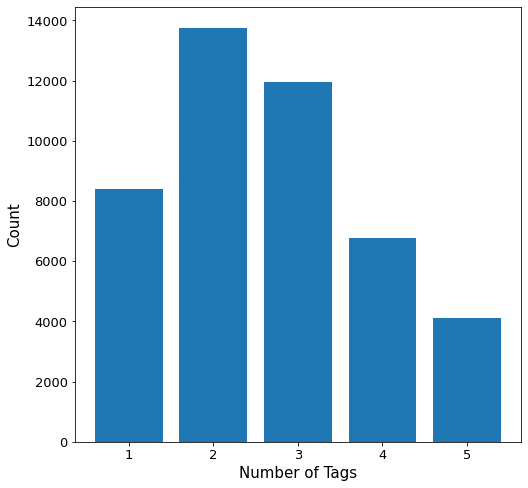

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(*np.unique(d['Num_Tags'], return_counts=True))
plt.xlabel('Number of Tags',size=15)
plt.ylabel('Count',size=15)
plt.tick_params(which='both',axis='both',labelsize=13)
plt.savefig("Tags_barplot.jpg",dpi=500,bbox_inches='tight')
files.download("Tags_barplot.jpg")

2 tags are used by the largest number of questions followed by 3,1,4,5.

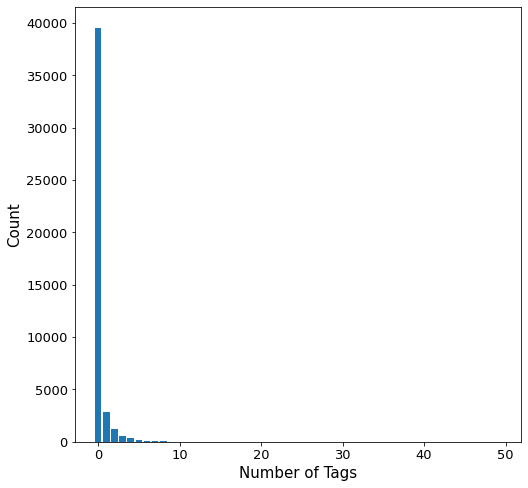

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(*np.unique(d['Extra_tags'], return_counts=True))
plt.xlabel('Number of Tags',size=15)
plt.ylabel('Count',size=15)
plt.tick_params(which='both',axis='both',labelsize=13)
#plt.savefig("Tags_barplot.jpg",dpi=500,bbox_inches='tight')
#files.download("Tags_barplot.jpg")

Very few questions out of 45000 used multiple tags for presentation such as bold, emphasis, headings etc.

In [ ]:
d['Num_Tags'].describe()

count    45000.000000
mean         2.653867
std          1.204031
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: Num_Tags, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


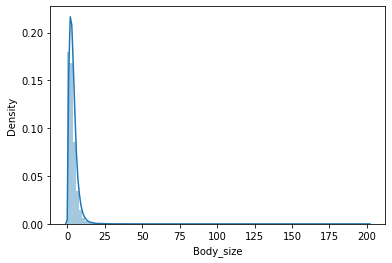

In [ ]:
sns.distplot(d['Body_size'],bins=100)

The distribution of the number of sentences used is highly skewed towards right.

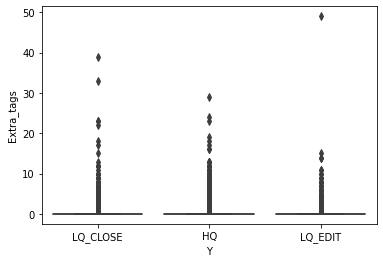

In [ ]:
sns.boxplot(x=d['Y'],y=d['Extra_tags'])

In [10]:
check = d[(d['Body_size']>10)]
check.shape

(1255, 12)

Very less number of questions have body_size more than 10/12.

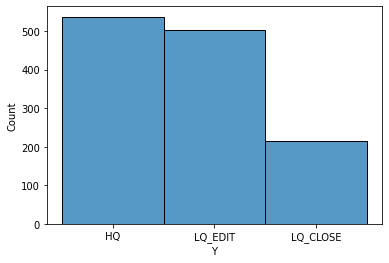

In [ ]:
sns.histplot(check['Y'])

In [ ]:
check.head(12)

,Title,Body,Tags,Y,Body_statements,Body_code,Code_blocks,Num_Tags,Tags_str,Body_size,Extra_tags,Code_Lines,Num Tags
64,"Can't find Python executable ""/path/to/executa...",<blockquote>\n <p>bufferutil@1.2.1 install /h...,<node.js><polymer-1.0><node-gyp><npm-install>,HQ,bufferutil@1.2.1 install /home/sudthenerd/poly...,node-gyp rebuild node-gyp rebuild,2,0,"[node.js, polymer-1.0, node-gyp, npm-install]",31,2,1,4.0
87,Passing a component as an 'argument' to anothe...,<p>I am new to web development and I have just...,<typescript><angular>,HQ,i am new to web development and i have just st...,<resource-item> <resource-item> <resource-a-it...,4,0,"[typescript, angular]",17,0,1,2.0
189,When I run it I get indentation Errors in many...,from sys import exit\r\n\r\ndef gold_room():\r...,<python><indentation>,LQ_EDIT,from sys import exit\r\n\r\ndef gold_room():\r...,,0,0,"[python, indentation]",22,0,0,2.0
192,Is this ER Diagram of a Bank Account correct?,"> • Each customer has a name, a permanent addr...",<relational-database><entity-relationship-model>,LQ_EDIT,"> • each customer has a name, a permanent addr...",,0,0,"[relational-database, entity-relationship-model]",16,0,0,2.0
279,iOS app rejected due to copyright issues,<p>an app I have been working on got rejected ...,<ios>,LQ_CLOSE,an app i have been working on got rejected by ...,,0,0,[ios],15,0,0,1.0
296,Only allow form submit of pdf/images not ever ...,<p>Hi I have a website which the page logic sh...,<javascript><php><html><wordpress>,LQ_CLOSE,hi i have a website which the page logic shoul...,"<?php\nini_set('display_errors', 'off');\n$to ...",2,0,"[javascript, php, html, wordpress]",13,0,170,4.0
318,When OutofMemory error occurs in Android?,I am parsing JSON String fetched from web.(Aro...,<android>,LQ_EDIT,i am parsing json string fetched from web.(aro...,,0,0,[android],14,0,0,1.0
405,react / redux-form: how to return promise from...,"<p>I'm trying to wrap my head around <a href=""...",<javascript><forms><reactjs><redux><redux-form>,HQ,"i am trying to wrap my head around redux, reac...","import React, {Component, PropTypes} from 'rea...",23,0,"[javascript, forms, reactjs, redux, redux-form]",14,5,102,5.0
428,Securing a PHP Server from a Hijacker,<p><strong>BACKGROUND:</strong> I'm implementi...,<php><security><session>,LQ_CLOSE,background: i am implementing a php server wit...,,0,0,"[php, security, session]",16,3,0,3.0
437,"ArrayList project at college, some questions","So hey guys I have some things to ask,\r\n\r\n...",<java><oop><arraylist>,LQ_EDIT,"so hey guys i have some things to ask,\r\n\r\n...",,0,0,"[java, oop, arraylist]",16,0,0,3.0


In [ ]:
print(check.loc[38567,'Body_statements'])

the problem with my code is that it simply will not run in the way i wish it would. it will only read from the first "while" & "if" condition. it simply does not recognize the other conditions. the age and score will be provided from an external source, therefore this is just an algorithm/scoring system for the tool.

public class algorithm_tester {

int score;

int age;

public static void main(string[] args) {

int score = 0;

int age = 0;


while (age <30) {

if(score <15) {

system.out.println("your score is slightly abnormal for your age.");

}

else if(score <10) {

system.out.println("your results are rather low. therefore, we recommend you seek medical advice.");

}

else if(score <8){

system.out.println("your results suggest severe cognitive impairment. you must seek medical attention immediately.");

}

else {

system.out.println("well done! you scored very well.");

}

while (age <40) {

if (score < 14) {

system.out.println("your results are slightly abnormal for your age.

In [ ]:
from wordcloud import WordCloud

def make_wc(word_freq,max_words=50):
    wordcloud = WordCloud(background_color='white',collocations=False,max_font_size=50, max_words=max_words).generate_from_frequencies(word_freq)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.show()
    plt.savefig('wordcloud.jpg',dpi=1000)
    wordcloud.to_file('WordCloud.png')

In [10]:
freq = {}
for i in words:
    if i in freq.keys():
        freq[i] += 1
    else:
        freq[i] = 1

In [11]:
dict(sorted(freq.items(), key=lambda item: item[1],reverse=True))

{'javascript': 5385,
 'python': 5041,
 'java': 4677,
 'android': 3573,
 'c#': 3137,
 'php': 3125,
 'html': 2562,
 'c++': 2263,
 'css': 1594,
 'jquery': 1410,
 'c': 1383,
 'arrays': 1367,
 'ios': 1339,
 'sql': 1243,
 'mysql': 1166,
 'swift': 1156,
 'angular': 1096,
 'python-3.x': 991,
 'reactjs': 873,
 'r': 862,
 'regex': 833,
 'node.js': 793,
 'sql-server': 792,
 'string': 733,
 'json': 731,
 'typescript': 647,
 'linux': 481,
 'excel': 473,
 'docker': 467,
 '.net': 433,
 'list': 424,
 'pandas': 418,
 'android-studio': 391,
 'react-native': 383,
 'ruby': 376,
 'vba': 372,
 'laravel': 357,
 'xcode': 354,
 'asp.net': 351,
 'flutter': 347,
 'git': 330,
 'go': 325,
 'firebase': 321,
 'database': 320,
 'kotlin': 312,
 'bash': 311,
 'amazon-web-services': 309,
 'angularjs': 295,
 'algorithm': 293,
 'visual-studio': 287,
 'function': 284,
 'django': 281,
 'python-2.7': 274,
 'vue.js': 268,
 'asp.net-core': 255,
 'spring': 252,
 'wordpress': 250,
 'ruby-on-rails': 248,
 'oracle': 247,
 'windows

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

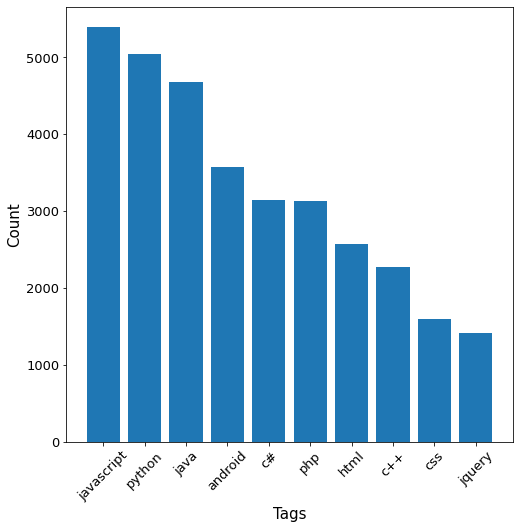

In [5]:
from google.colab import files
c = [5385,5041,4677,3573,3137,3125, 2562,2263,1594,1410]
d = ['javascript','python','java','android','c#','php','html','c++','css','jquery']
plt.figure(figsize=(8,8))
plt.bar(d,c)
plt.xlabel("Tags",size=15)
plt.ylabel("Count",size=15)
plt.tick_params(which='both',axis='both',labelsize=13)
plt.xticks(d,rotation=45)
plt.savefig("TagsBar.jpg",dpi=500,bbox_inches='tight')
files.download("TagsBar.jpg")

The plot above shows top 10 tags used along with the number of questions they were used in.

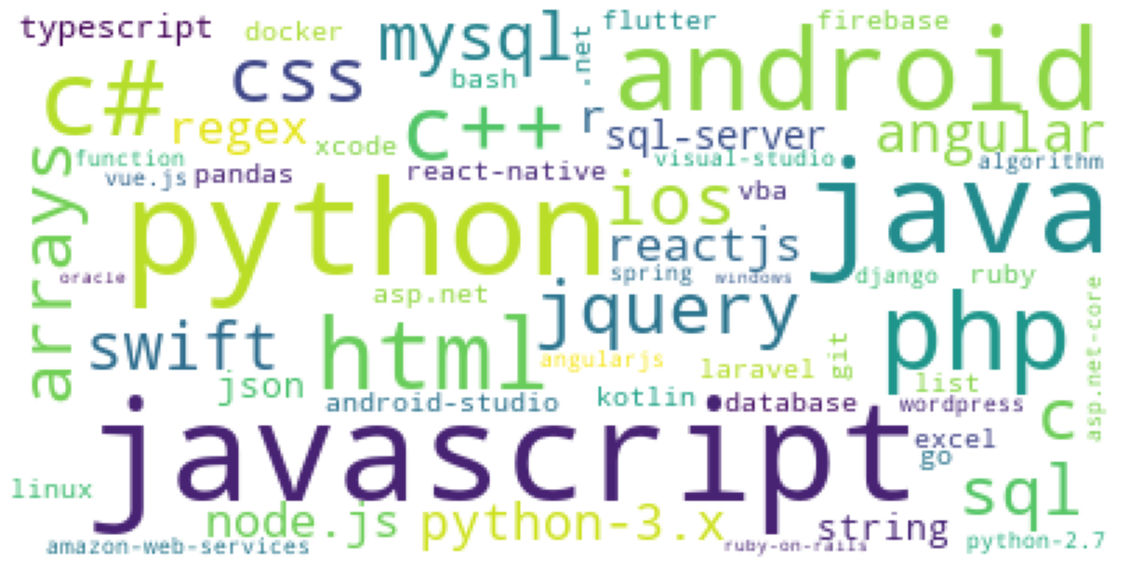

In [ ]:
freq = {}
for i in words:
    if i in freq.keys():
        freq[i] += 1
    else:
        freq[i] = 1
make_wc(freq,60)

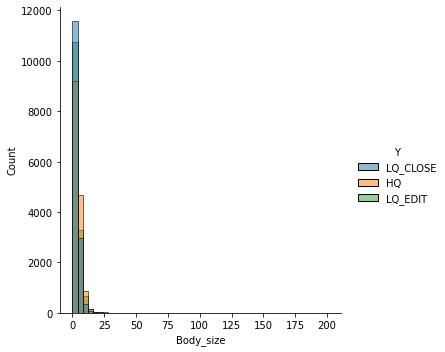

In [ ]:
sns.displot(d,hue='Y',x='Body_size',bins=50)

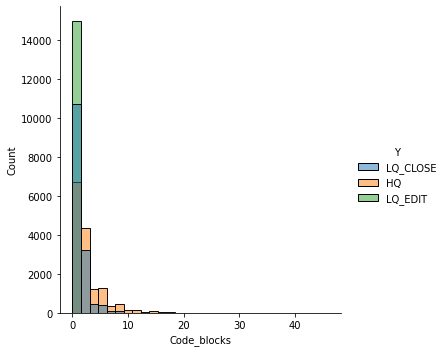

In [ ]:
sns.displot(d,hue='Y',x='Code_blocks',bins=30)

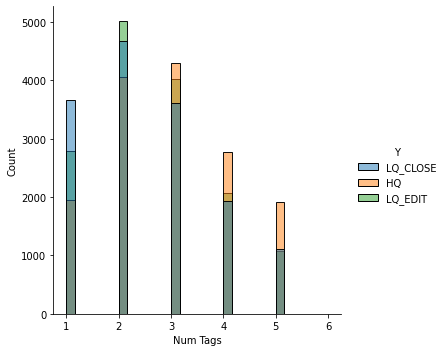

In [ ]:
sns.displot(d,x='Num Tags',hue='Y',bins=30)

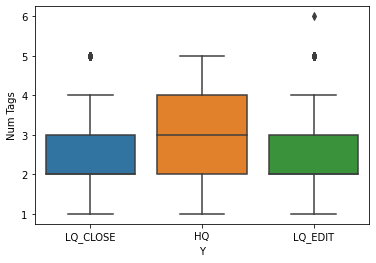

In [ ]:
plt.figure(figsize=(8,8))
sns.boxplot(x=d['Y'],y=d['Num Tags'])
plt.tick_params(which='both',axis='both',labelsize=13)
plt.title("Frequencies of labels",size=17)
plt.savefig("TagsDist.jpg",dpi=500,bbox_inches='tight')
files.download("TagsDist.jpg")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

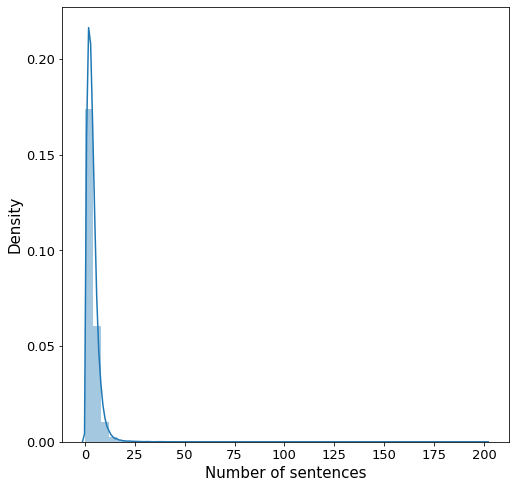

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(d['Body_size'])
plt.tick_params(which='both',axis='both',labelsize=13)
plt.savefig("body size dist.jpg",dpi=500,bbox_inches='tight')
files.download("TagsDist.jpg")

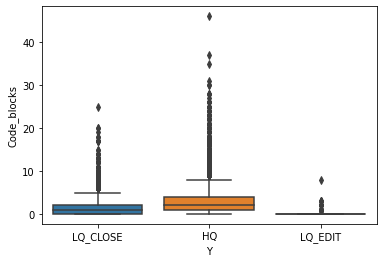

In [ ]:
sns.boxplot(x=d['Y'],y=d['Code_blocks'])

In [ ]:
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 576x576 with 0 Axes>

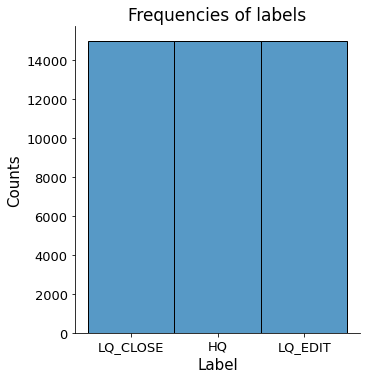

In [ ]:
plt.figure(figsize=(8,8))
sns.displot(d,x='Y',bins=10)
plt.xlabel('Label',size=15)
plt.ylabel('Counts',size=15)
plt.tick_params(which='both',axis='both',labelsize=13)
plt.title("Frequencies of labels",size=17)
plt.savefig("TagsDist.jpg",dpi=500,bbox_inches='tight')
files.download("TagsDist.jpg")

The classes are perfectly balanced

In [ ]:
d.columns

Index(['Title', 'Body', 'Tags', 'Y', 'Body_statements', 'Body_code',
       'Code_blocks', 'Num_Tags', 'Tags_str', 'Body_size', 'Extra_tags',
       'Code_Lines'],
      dtype='object')

In [ ]:
from scipy.stats import pointbiserialr
new_values = {'HQ':2, 'LQ_EDIT':1, 'LQ_CLOSE':0}
y = d['Y'].replace(new_values)
contvarscols = ['Code_blocks','Body_size','Extra_tags','Code_Lines']

for i in range(len(contvarscols)):
    print(contvarscols[i])
    print(pointbiserialr(y,d[contvarscols[i]]))


Code_blocks
PointbiserialrResult(correlation=0.2534562621571178, pvalue=0.0)
Body_size
PointbiserialrResult(correlation=0.13037186329470823, pvalue=8.969763154558329e-170)
Extra_tags
PointbiserialrResult(correlation=0.11147864783154782, pvalue=2.1635018813059796e-124)
Code_Lines
PointbiserialrResult(correlation=0.012837805104096283, pvalue=0.0064624282306126645)


Point Biserial correlation is very low. Thus, the extra features generated may not matter that much in the classification.

In [ ]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

print(cramers_V(d['Y'],d['Num_Tags']))

0.013340410093256226


In [14]:
data_new = d[['Code_blocks','Body_size','Extra_tags','Code_Lines','Y']]
data_new.columns

Index(['Code_blocks', 'Body_size', 'Extra_tags', 'Code_Lines', 'Y'], dtype='object')

No handles with labels found to put in legend.


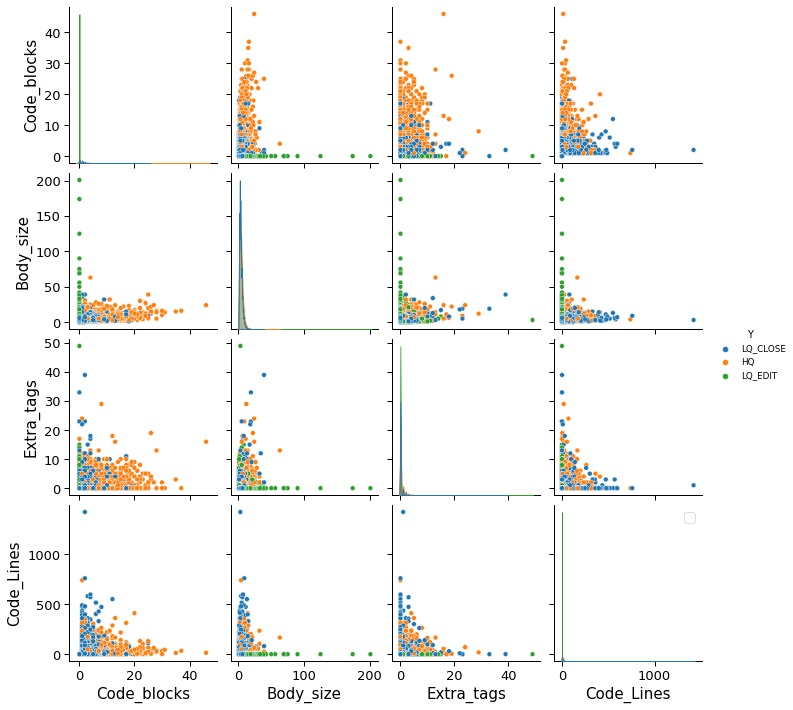

In [18]:
sns.set_context("paper", rc={"axes.labelsize":15,"xtick.labelsize":13,"ytick.labelsize":13})
ax = sns.pairplot(data_new,hue='Y')
plt.legend(fontsize='x-large', title_fontsize='13')
plt.savefig("Pairplot.jpg",dpi=500,bbox_inches='tight')

No specific patter is observed between the extra features and the class. The observation that can be made is the distrbution of all the extra features us skewed towards right.

In [19]:
files.download("Pairplot.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>